In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
# importing data
train = pd.read_hdf('../car.h5')
test = pd.read_hdf('../test.car_price.h5')
print(train.shape)
print(test.shape)

(106494, 155)
(54122, 153)


In [6]:
train.sample()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
136986,"[Osobowe, Nissan, Navara]","10:32, 5 marca 2018",PLN,"Cena Netto, Faktura VAT",33000.0,"Opolska 188 - 52-013 Wrocław, Krzyki (Polska)",Idea Getin Leasing SA,Dealer,False,False,...,None,Używane,None,None,None,None,None,None,None,136986


In [7]:
test.sample()

,breadcrumb,created_at,price_currency,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
2914,"[Osobowe, BMW, Seria 3, 320, BMW Seria 3 E90 (...","12:29, 3 marca 2018",PLN,"ALEJE PIŁSUDSKIEGO 1 - 33-300 Nowy Sącz, Małop...",Ponad 500 aut w Jednym Miejscu/Autoryzowany Sa...,Dealer,False,False,True,True,...,None,Używane,E90 (2005-2012),None,None,None,Tak,None,None,2914


In [11]:
df = pd.concat([train, test], sort=False)
del train, test
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160616 entries, 0 to 160613
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 116.1+ MB


In [12]:
# settings changed so all data will be displayed
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head(3)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [17]:
# Target variable (car price) has two currencies
df['price_currency'].value_counts()

PLN    160288
EUR       328
Name: price_currency, dtype: int64

In [18]:
# normalizing target variable to one currency using function shown above

def normalize_price_value(x):
#     if str(x['price_value']) == 'nan'
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

In [19]:
df.sample(10)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN
126248,"[Osobowe, Škoda, Roomster]","20:20, 1 marca 2018",PLN,Cena Brutto,10900.0,"Zabrnie 810 - 39-410 Grębów, tarnobrzeski, Pod...",LukTRANS,Dealer,False,False,True,False,False,True,True,True,True,True,True,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,Fals

Text(0.5, 1.0, 'price_value_PLN_log')

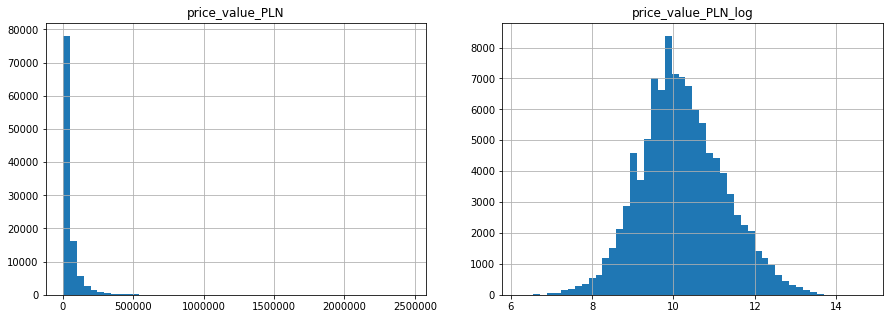

In [20]:
# It seems that sing logarithm of target variable is worth looking into

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN')
plt.subplot(1,2,2)
np.log1p(df['price_value_PLN']).hist(bins=50);
plt.title('price_value_PLN_log')

In [21]:
# logarithmic target variable is created
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

In [22]:
# all missing data is replaced with -1
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

9013997


0

In [23]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

In [25]:
# Dummy model for reference
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

33565.50506397786

# feature engineering 

In [54]:
def get_X_y_and_cros_val(model, feats, log=False): # cross validation with option to use logarithmic target variable
    train_df = df[ df['price_value_PLN'] != -1]
    X = train_df[ feats ].values
    y = train_df['price_value_PLN'].values if not log else train_df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        
        
        y_pred = train_model.predict(X[test_idx])
        y_pred = np.expm1(y_pred) if log else y_pred
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    return scores, np.std(scores)

In [26]:
# all sets of features will be tested on the same model:
model = DecisionTreeRegressor(max_depth=5, random_state=0)

In [27]:
# first try: only bool features since it requiers no additional work
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

In [55]:
# original target variable
get_X_y_and_cros_val(model, feats, log=False)

NameError: name 'df' is not defined

In [29]:
#logarithmic target variable. Unfortunately score has worsen, will be double checked later.
get_X_y_and_cros_val(model, feats, log=True)

([732.0390823912635, 757.5084141886247, 711.0088035505258], 19.01219865658784)

In [30]:
df.select_dtypes([np.object]).sample(10)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
98857,"[Osobowe, Volvo, V60]","14:48, 28 lutego 2018",PLN,"Cena Brutto, Faktura VAT","Kartuska 410 - 80-125 Gdańsk, Jasień (Polska)",DRYWA ADV,Dealer,-1,-1,Volvo,-1,-1,-1,-1,-1,-1,-1,5 km,Tak,2018,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kombi,-1,Tak,Manualna,-1,-1,-1,-1,Tak,Firmy,152 KM,-1,Polska,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,V60,2 000 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Inny kolor,-1,-1,Nowe,-1,-1,-1,-1,Tak,-1,-1
50382,"[Osobowe, Mitsubishi, Outlander, Mitsubishi Ou...","14:00, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji","Myszków, myszkowski, Śląskie",-1,Osoba prywatna,-1,-1,Mitsubishi,-1,-1,-1,-1,-1,-1,-1,245 000 km,-1,2010,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,4x4 (stały),-1,SUV,-1,Tak,Automatyczna hydrauliczna (klasyczna),-1,-1,-1,-1,Tak,Osoby prywatnej,-1,-1,Niemcy,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,Outlander,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,II (2006-2013),-1,-1,-1,Tak,-1,-1
90238,"[Osobowe, BMW, X6, BMW X6 F16 (2014-)]","11:02, 4 marca 2018",PLN,-1,"Wystawowa 2 - 25-672 Kielce, Świętokrzyskie (P...",Dealer BMW ZK Motors,Dealer,5,-1,BMW,-1,-1,5,-1,-1,-1,-1,5 km,Tak,2017,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,Tak,-1,-1,4x4 (stały),-1,SUV,Tak,-1,Automatyczna hydrauliczna (klasyczna),-1,-1,-1,-1,-1,Firmy,313 KM,-1,Polska,-1,-1,-1,Diesel,Tak,-1,-1,-1,-1,-1,-1,X6,2 993 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Czarny,-1,-1,Nowe,F16 (2014-),-1,-1,-1,Tak,-1,-1
21860,"[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","15:21, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji","Środa Wielkopolska, średzki, Wielkopolskie",-1,Osoba prywatna,5,-1,Ford,-1,-1,5,-1,-1,-1,-1,104 300 km,-1,2010,WF0JXXGAJJAY28015,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Auta miejskie,Tak,-1,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,90 KM,-1,Belgia,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,Fiesta,1 600 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Niebieski,-1,-1,Używane,Mk7 (2008-),-1,-1,-1,-1,-1,-1
28733,"[Osobowe, Nissan, Primera, Nissan Primera P12 ...","18:01, 28 lutego 2018",PLN,"Cena Brutto, Do negocjacji","Skrowaczewskiego 32 - 96-300 Żyrardów, żyrardo...",AUTOSELEKCJA,Dealer,5,-1,Nissan,-1,-1,5,-1,-1,-1,-1,172 000 km,-1,2004,-1,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kombi,Tak,-1,Manualna,-1,-1,-1,-1,Tak,Firmy,115 KM,-1,Niemcy,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,Primera,1 796 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,P12 (2001-2007),-1,-1,-1

In [31]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja', 'param_first-registration']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns

In [32]:
# Function used to find columns carrying the same information (used on columns picked after feature importance check)
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of {} in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 91
occurrences of Manualna in param_skrzynia-biegów: 110590


In [33]:
df['param_skrzynia-biegów'].unique()

array(['Manualna', 'Automatyczna hydrauliczna (klasyczna)',
       'Automatyczna dwusprzęgłowa (DCT, DSG)', -1,
       'Automatyczna bezstopniowa (CVT)',
       'Półautomatyczna (ASG, Tiptronic)'], dtype=object)

In [34]:
def check_if_complementing(feat1, feat2): # count of instances when data only in one of the columns
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)

In [35]:
# before merging columns were checked if they contain data that is complementary or just duplicates
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 145688, 'param_door-count': 117, 'both': 0}

{'param_przebieg': 159945, 'param_mileage': 127, 'both': 0}

{'param_pojemność-skokowa': 152840, 'param_engine-capacity': 122, 'both': 0}

{'param_emisja-co2': 3114, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 160327, 'param_year': 128, 'both': 0}

{'param_rodzaj-paliwa': 160327, 'param_fuel-type': 128, 'both': 0}

{'param_moc': 146331, 'param_engine-power': 115, 'both': 0}

{'param_marka-pojazdu': 160327, 'param_make': 128, 'both': 0}

{'param_napęd': 135893, 'param_transmission': 110, 'both': 0}

{'param_skrzynia-biegów': 151750, 'param_gearbox': 121, 'both': 0}



In [36]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]

In [37]:
# merge data in 'doubles' dictionary
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)
    
# delete no longer needed columns
to_delate = doubles.values()
for d in to_delate:
    del df[d]

###### Caterogical features

In [38]:
# picking categorical features form df
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_country-of-origin__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_color__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_leasing__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_kraj-pochodzenia__cat',
 'param_serwisowany-w-aso__cat',
 'param_rodzaj-paliwa__cat',
 'param_możliwość-finansowania__

In [39]:
# model trained with bool and categorical features. Score improved.
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats)

([23186.965235161915, 23257.65899578091, 23379.309697617235],
 79.43753191096627)

In [41]:
# plotting categorical features to look for potentially important ones
# categories are sorted by value_counts






# cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

# for cat_feat in cat_feats:
#     if cat_feat not in cat_no_plot:
#         cat_name = cat_feat[:-len(cat_feat_prefix)]
#         plt.figure(figsize=(20,5))
#         sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
#         plt.xticks(rotation=90);
#         plt.show()

###### numerical features

In [42]:
# numerical features picked from df
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [43]:
df['param_moc'].sample(5)

50766     80 KM
40040    126 KM
12122    141 KM
30985    110 KM
33171    125 KM
Name: param_moc, dtype: object

In [44]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val

In [45]:
# pulling numerical data from strings
num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

# df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

In [52]:
# model trained with bool, categorical and numerical features. Score significantly improved.
feats = list(bool_feats) + list(cat_feats) + list(num_feats)

get_X_y_and_cros_val(model, feats, log=False)

([14198.374124514625, 14763.79421947926, 14567.378956949546],
 234.38889941120337)

In [ ]:
# Double checking with logarithmic target variable
get_X_y_and_cros_val(model, feats, log=True)

In [ ]:
# after each iteration of feature engineering feature importance and permutation importance was checked
# to look for features worth working on in next iteration

X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

In [ ]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

# Preparing test train set

In [46]:
df[ df['price_value_PLN'] == -1 ].shape

(54122, 213)

In [53]:
train = df[ df['price_value_PLN'] != -1]
test = df[ df['price_value_PLN'] == -1 ]

del df

In [50]:
print(train.shape)
print(test.shape)

(106494, 213)
(54122, 213)


# Model selection and optimization

'Permutation importance' above sugest that only 9 features heave any impact on model training.

In [56]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
less_feats = ['param_rok-produkcji__num','param_moc__num','param_rodzaj-paliwa__cat','param_przebieg__num','param_marka-pojazdu__cat','param_napęd__cat','param_skrzynia-biegów__cat','param_liczba-drzwi__num','param_pojemność-skokowa__num']

In [61]:
# Since using logarithm of target vartiable did not bring results
# all models will be tested on the same set of features using standard 3 fold cross_val_score
def get_X_y(feats):
    return train[ feats ].values, train['price_value_PLN'].values

def test_model(model, feats):
    X, y = get_X_y(feats)
    
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return np.abs(np.mean(scores)), np.std(scores)

def plot_fi_lc_e5(model, feats, pi=True, lc=True, e5=False):
    X, y = get_X_y(feats)
    model.fit(X, y)
    
    if pi == True:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc == True:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5 == True:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

In [62]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model, feats)

(10696.56460327827, 141.48270510632702)

In [63]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model, less_feats)

(10876.154516893592, 55.372783128649544)

Scores obove show that score with more features is bettor so all features will be used for now.

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

In [ ]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

In [ ]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = XGBRegressor(**xgb_params)
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

In [ ]:
# Since XBG looks most promising it gets hyper optimized

X = df[feats].values
y = df['price_value_PLN'].values

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

    print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

In [ ]:
# checking hyperopt parameters

xgb_params_opt = {'colsample_bytree': 0.8788921383871157,
                  'learning_rate': 0.10169026353664928,
                  'max_depth': 13,
                  'min_child_weight': 1,
                  'subsample': 0.8444300922311613,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params_opt)

In [ ]:
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

Model seems to be a bit over fitted so parameters were changed to:

In [71]:
xgb_params = {'colsample_bytree': 0.8,
                  'learning_rate': 0.1,
                  'max_depth': 10,
                  'min_child_weight': 1,
                  'subsample': 0.8,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params)
test_model(model, feats)

(6738.599588109845, 33.00576904039893)

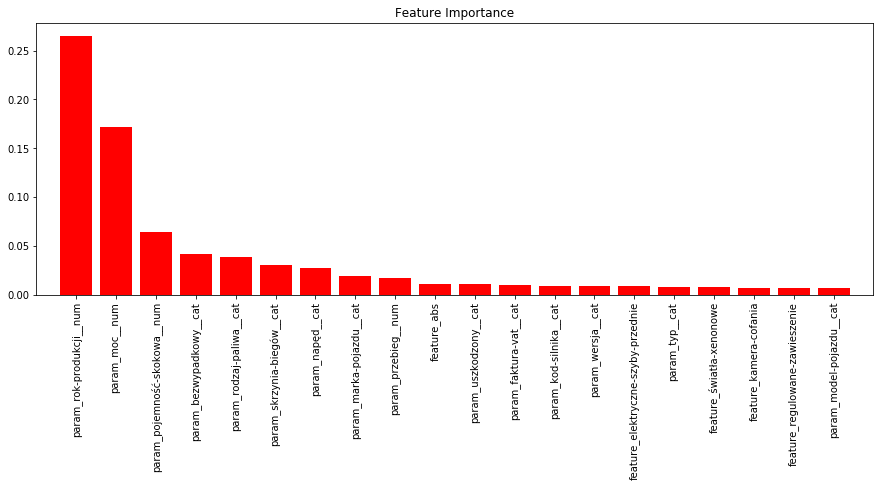

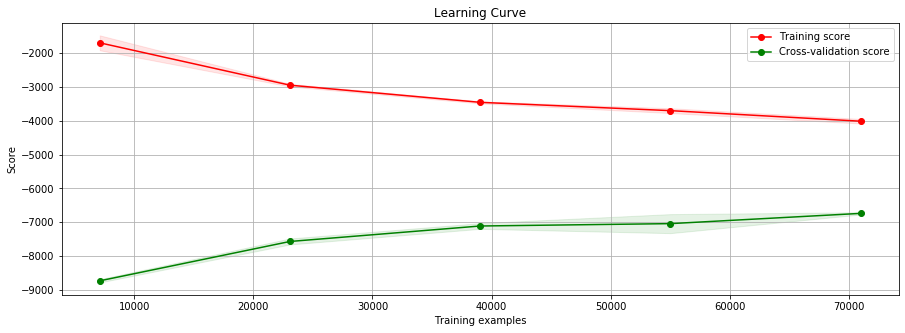

In [65]:
plot_fi_lc_e5(model, feats, True, True, False)

# Final predict and submit data preparation

In [66]:
test.sample()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_country-of-origin__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_color__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,pa

In [74]:
model = XGBRegressor(**xgb_params)

model.fit(train[feats], train['price_value_PLN'])
test['price_value_PLN'] = model.predict(test[feats])
test['price_value'] = test[['price_value_PLN', 'price_currency']].apply(lambda x: x['price_value_PLN'] if x['price_currency'] == 'PLN' else x['price_value_PLN'] / 4.5, axis =1)

test[ ['car_id', 'price_value'] ].to_csv('../car_test_predict.csv', index=False)

# Error analysis

In [ ]:
X, y = get_X_y(feats)

y_pred = cross_val_predict(model, X, y, cv=3)
df['pred'] = y_pred
df['error'] = df[['pred', 'price_value_PLN']].apply(lambda x: np.abs(x['pred'] - x['price_value_PLN']), axis=1)

In [ ]:
less_feats + ['error']

In [ ]:
df[less_feats + ['error']].sort_values('error', ascending=False)

In [ ]:
df.groupby('param_rodzaj-paliwa')['error'].agg(np.max).reset_index().sort_values('error', ascending=False)

In [ ]:
for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        order = df.groupby(cat_name)['error'].agg(np.mean).reset_index().sort_values('error', ascending=False)[cat_name]
        sns.barplot(x=cat_name, y='error', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

In [ ]:
feat_mea = {}
for feat in feats:
    